# TweetToVect

## Idea
Crear embeddgins de tweets.

INPUT:<br>
Array de embeddings de fasttext (ver WordEmbeddings.ipynb)<br>

OUTPUT:<br>
Embeddings (100d) de tweet.
<img src='img/red_tweet_to_vect.jpg' />

In [279]:
import pandas as pd
import numpy as np
import gensim
import seaborn as sns
from matplotlib import pyplot
import sys
import math

In [2]:
word_model = gensim.models.fasttext.load_facebook_vectors("../models/words_fast_text.bin")

In [3]:
print('Length of vectors', len(word_model.get_vector('Hola')))

Length of vectors 100


In [4]:
df = pd.read_pickle('../datasets/tweets_cleaned.pkl')

In [5]:
df = df[df.lang=='es']

In [6]:
df.sample(20).full_text

1287236859710627840       comodoro suma dos nuevos casos de covid 19 URL
1287198450312863745    rio de janeiro busca un nuevo modelo para su f...
1145767408327634944    algunas postales de nuestra festejo en el barr...
1213451684636172288    hay que desmitificar el tema de dónde comprar ...
1287760108911570944                                tránsito interrumpido
638554270204305408     compartimos el programa nº 9 de @ lparlamentar...
1244111854080872449    @ leoricciardino leo querido yo estoy leyendo ...
1278097411597111298    # detrásdelasnoticias con el profe @ romerodia...
1278822103337353218    @ nicolasacade1 @ martinarauzok @ backup_83 @ ...
1228106636268638208    el crecimiento sostenido # whatsapp se transfo...
894955183272189953     no debe sorprendernos que sean implacables al ...
1056271642920435712    con la grandiosa @ elena_roger hoy sigo record...
1263481469613326337    coronavirus en la argentina desde el gobierno ...
1199742990618681344    luego de 5 años de espera ho

In [35]:
tokenize = lambda text: text.split(' ')
df_word_sample = df.sample(1000000)
tweets_l = df_word_sample.full_text.apply(lambda text: len(tokenize(text)))

Cantidad de palabras por tweet (100.000 tweets):


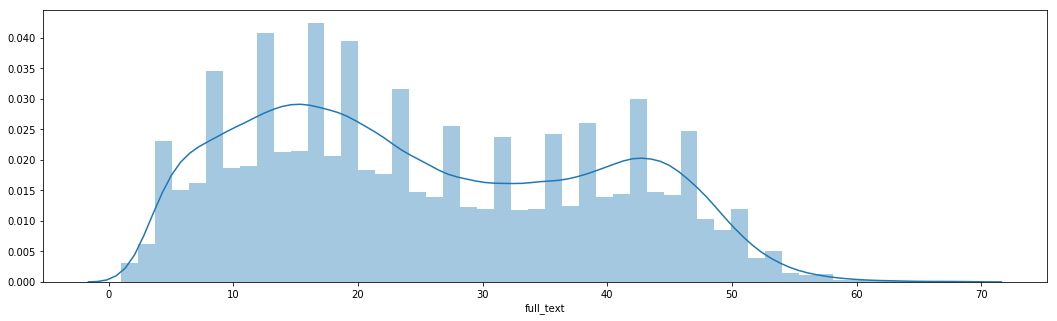

In [39]:
print('Cantidad de palabras por tweet (100.000 tweets):')
fig, ax = pyplot.subplots(figsize=(18,5))
sns.distplot(tweets_l[tweets_l<70])
pyplot.show()

In [19]:
long_tweets = df_word_sample[tweets_l>40].full_text.values[:5]
for i in long_tweets:
    print(i)
    print('')

lamentamos el fallecimiento de virgilio tedín uriburu quien fuera el presidente del fondo nacional de las artes entre 2013 y 2015 en cada lugar que visito cada artista que veo me encuentro con una forma de pensar de ver la argentina que nos enriquece URL

acuerdo económico nacional después de protestas por el hambre oficialismo y oposición corrieron a llegar a un acuerdo no los une el amor sino el espanto el miedo a un nuevo estallido y por eso entregan un bono en torno a la línea de la pobreza y un plan pro empresarios

qué pasa con las mudanzas ? compartimos la nota de @ de12a14 realizada al fiscal a cargo de la unidad especializada para atender delitos relacionados con el coronavirus del ministerio público de la acusación dr gustavo ponce ashad 📺 🎥 🎙 @ ciro6as @ daniamoroso @ analiabocassi URL

🗳 ayer se celebraron las primeras elecciones importantes en tiempos de coronavirus las legislativas en corea del sur se registró la tasa de participación más alta en la historia democrática d

In [21]:
short_tweets = df_word_sample[tweets_l < 30].full_text.values[:5]
for i in short_tweets:
    print(i)
    print('')

@ alejokassabian me llego el mensaje por varias personas abrazo capo cuando puedas te mando un presente de don arturo

y el premio ley de godwin 2020 es para URL

una pavada nomás

@ lucianoblanco38 la más linda de todas !

será exhibido en los próximos días en los locales que cumplan con los protocolos de bioseguridad para evitar la propagación del covid 19 URL



## Estrategia para lidiar con los largos de los tweets
La red va a terner 2 inputs:
- t1 t2 ... t20 (inicio de la frase)
- t-1 t-2 ... t-20 (frase invertida)

Los tweets muy cortos seran repetidos máximo una vez. Si su largo no alanza, se completa con padding.

In [51]:
def get_vectors(tweet, length=20, dim=100):
    arr = [ word_model.get_vector(w) for w in tokenize(tweet) ]
    arr = arr+arr
    arr_inv = arr[::-1]
    arr = np.array(arr)
    arr_inv = np.array(arr_inv)
    if(len(arr)==length):
        return [arr, arr_inv]
    elif(len(arr)<length):
        to_add = np.zeros((length - len(arr), dim))
        return [np.concatenate([arr, to_add]), np.concatenate([arr_inv, to_add])]
    else:
        return [arr[0:length], arr_inv[0:length]]

print(get_vectors('hi this is a tweet')[0].shape)
print(get_vectors('hi this is a very very very very very very very very very very very very very very very long tweet with more than 25 words ! 😊')[0].shape)

(20, 100)
(20, 100)


In [52]:
get_vectors('hi this is a tweet')

[array([[ 0.10836364,  0.0278185 , -0.50520957, ..., -0.569399  ,
         -1.03965211,  0.40383402],
        [ 0.53312916,  0.19095655, -0.02953227, ...,  0.11897559,
         -1.57449877, -0.24043569],
        [ 0.48872438,  0.04325911,  0.51331085, ..., -0.14464097,
         -0.72130805, -0.39419889],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.24735637, -0.20309554,  0.60416889, ..., -0.3391051 ,
         -0.73890144,  0.35681111],
        [ 0.207982  ,  0.05754891, -0.00807469, ..., -0.08669736,
         -0.04393448, -0.00296706],
        [ 0.48872438,  0.04325911,  0.51331085, ..., -0.14464097,
         -0.72130805, -0.39419889],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

## keras transformer

In [53]:
import tensorflow_addons as tfa
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  
import tensorflow as tf
from tensorflow.python import keras

In [185]:
tf.__version__

'2.2.0'

In [217]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads
        })
        return config
        
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.att = MultiHeadSelfAttention(embed_dim, num_heads, **kwargs)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, sentence_length, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=sentence_length, output_dim=embed_dim)

    def call(self, x):
        return x
        positions = tf.range(start=0, limit=len(x), delta=1)
        positions = self.pos_emb(positions)
        return x + positions
    
class UpscaleDense(layers.Layer):
    def __init__(self, heads, units, activation='relu'):
        super(UpscaleDense, self).__init__()
        self.heads = heads
        self.units = units
        self.denseLayer = layers.Dense(units, activation=activation)
    def call(self, x):
        x_ = [self.denseLayer(x) for _ in range(self.heads)]
        x_ = tf.keras.backend.stack(x_, axis=1)
        
        positional = layers.Embedding(input_dim=self.heads, output_dim=self.units)(tf.range(start=0, limit=25, delta=1))
        
        return x_ + positional
    
def upscaleDense(x, heads, units, activation='relu'):
    denseLayer = layers.Dense(units, activation=activation)
    x_ = [denseLayer(x) for _ in range(heads)]
    x_ = tf.keras.backend.stack(x_, axis=1)
    positional = layers.Embedding(input_dim=heads, output_dim=units)(tf.range(start=0, limit=25, delta=1))
    return x_

In [309]:
maxlen = 20  # Only consider the first 20 words of each tweet
embed_dim = 100  # Embedding size for each token
num_heads = 50  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,embed_dim), name='input')
inputs_inv = layers.Input(shape=(maxlen,embed_dim), name='input_inv')

pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

positions = tf.range(start=0, limit=maxlen, delta=1)
positions_inv = tf.range(start=maxlen-1, limit=-1, delta=-1)

x = inputs + pos_emb(positions)
x_inv = inputs_inv + pos_emb(positions_inv)
x = layers.BatchNormalization(axis=1)(x)
x_inv = layers.BatchNormalization(axis=1)(x_inv)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x_inv = transformer_block(x_inv)
x = layers.BatchNormalization(axis=1)(x)
x_inv = layers.BatchNormalization(axis=1)(x_inv)

x = layers.Dense(20, activation='relu')(x) # shape=(None, 20, 20)
x_inv = layers.Dense(20, activation='relu')(x_inv) # shape=(None, 20, 20)
x = keras.layers.concatenate([x, x_inv], axis=1) #join both inputs
x = layers.BatchNormalization(axis=1)(x)

x = layers.Flatten()(x) # shape=(None, 500)
encoder_mu = layers.Dense(150, activation='linear', name='encoder_mu')(x)
encoder_log_var = layers.Dense(150, activation='linear', name='encoder_log_var')(x)

encoder = keras.Model(inputs={'vectors':inputs, 'vectors_inv':inputs_inv}, outputs=[encoder_mu, encoder_log_var], name='encoder')

decoder_input = layers.Input(shape=150)

upscaled = []
units = 50

for i in range(maxlen*2):
    x = layers.Dense(units, activation='relu')(decoder_input)
    x = layers.BatchNormalization(axis=1, name='ba_'+str(i))(x)
    x = layers.Dense(units*2, activation='linear', name='word_'+str(i))(x)
    upscaled.append(x)

decoder_output = tf.keras.backend.stack(upscaled, axis=1)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

def sampling(mu, log_var):
    epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
    return mu + K.exp(log_var / 2) * epsilon

# Pérdida de reconstrucción
def r_loss(y_true, encodings):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=2, reduction='auto')
    return cosine_loss(y_true, encodings)

# Divergencia KL
def kl_loss(mu, log_var):
    return -0.5 * K.sum(1 + log_var - K.square(mu)- K.exp(log_var), axis = 1)

def vae_loss(encoder, decoder, input_tensor):
    
    mu, log_var = encoder(data_batch['inputs'])
    encoded = sampling(mu, log_var)
    decoded = decoder(encoded)
    
    r_l = r_loss(data_batch['output'], decoded)
    
    loss = kl_loss(mu, log_var) + r_l * 10000
    return K.mean(loss), r_l

In [310]:
display(encoder.summary())
display(decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 20, 100)]    0                                            
__________________________________________________________________________________________________
input_inv (InputLayer)          [(None, 20, 100)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_AddV2_104 (TensorFl [(None, 20, 100)]    0           input[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_AddV2_105 (TensorFl [(None, 20, 100)]    0           input_inv[0][0]                  
____________________________________________________________________________________________

None

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 150)]        0                                            
__________________________________________________________________________________________________
dense_1796 (Dense)              (None, 50)           7550        input_41[0][0]                   
__________________________________________________________________________________________________
dense_1797 (Dense)              (None, 50)           7550        input_41[0][0]                   
__________________________________________________________________________________________________
dense_1798 (Dense)              (None, 50)           7550        input_41[0][0]                   
____________________________________________________________________________________________

None

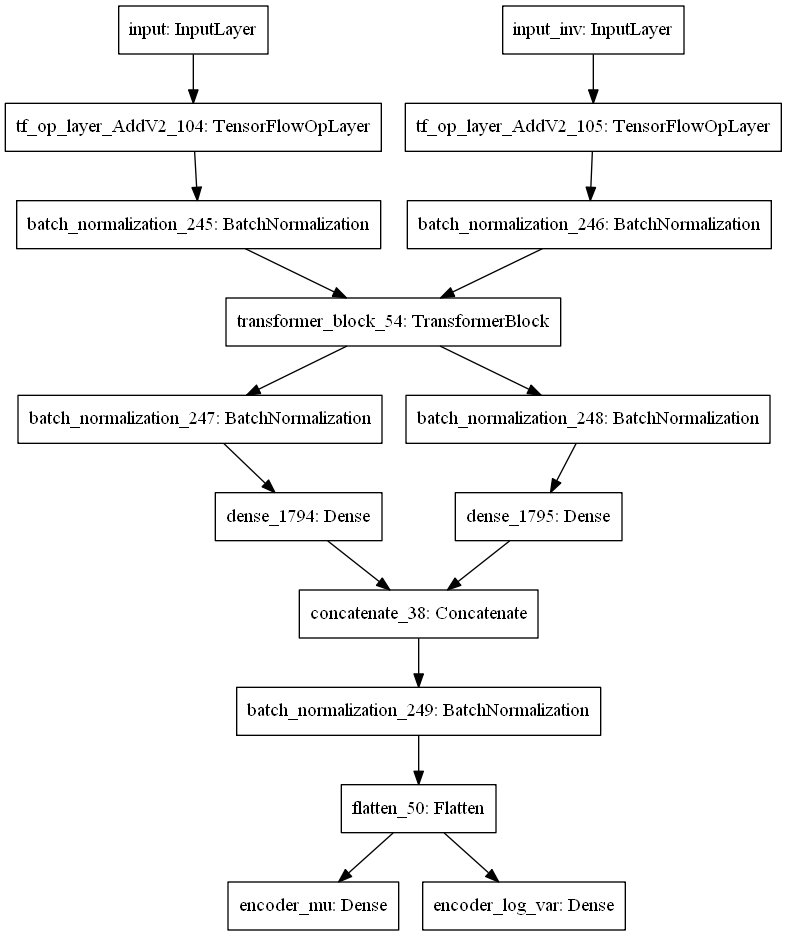

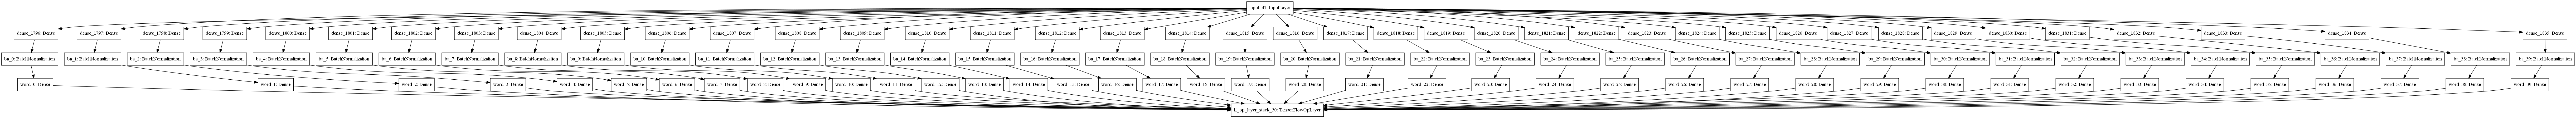

In [311]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from tensorflow.keras.utils import plot_model
display(plot_model(encoder))
plot_model(decoder)

## generator

In [258]:
def data_generator(df, batch_size, text_size=20, dim=100):
    while True:
        batch_df = df.sample(batch_size)
        vectors_list = batch_df.full_text.apply(lambda text: get_vectors(text, text_size, dim)).values
        vectors = np.array([tweet[0].tolist() for tweet in vectors_list])
        vectors_inv = np.array([tweet[1].tolist() for tweet in vectors_list])
        vectors_concat = np.concatenate([vectors, vectors_inv], axis=1)
        
        yield( {
            'inputs': {
                'vectors': vectors,
                'vectors_inv': vectors_inv
            },
            'output': vectors_concat
        } ) # x = y, autovector

In [331]:
def save_autoencoder(encoder, decoder, model_dir):
    model_json = encoder.to_json()
    with open(model_dir+"tweet_to_vect_encoder_a.json", "w") as json_file:
        json_file.write(model_json)
    encoder.save_weights(model_dir+"tweet_to_vect_encoder_a.h5")
#     print("Saved encoder to disk")
    
    model_json = decoder.to_json()
    with open(model_dir+"tweet_to_vect_decoder_a.json", "w") as json_file:
        json_file.write(model_json)
    decoder.save_weights(model_dir+"tweet_to_vect_decoder_a.h5")
#     print("Saved decoder to disk")
    
    return True

save_autoencoder(encoder, decoder, model_dir)

True

In [314]:
epochs = 100000
steps = 100
batch_size = 2**10
model_dir = '../models/'
history = []

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)

for e in range(epochs):
    for s in range(steps):
        with tf.GradientTape() as tape:
            data_batch = next(data_generator(df, batch_size))
            loss, r_l = vae_loss(encoder, decoder, data_batch)
            
        sys.stdout.write(f'\rEpoch {e+1}: step {s+1}/{steps} \t loss {round(float(loss), 2)} \t r_loss {r_l}')
        sys.stdout.flush()
            
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        grads = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(grads, trainable_variables))
        if(s+1==steps):
            print('')
            history.append([loss, r_l])
            try:
                save_autoencoder(encoder, decoder, model_dir)
            except:
                print('ERROR ON SAVE')

Epoch 1: step 100/100 	 loss -5329.81 	 r_loss -0.5397324562072754
Epoch 2: step 100/100 	 loss -5191.65 	 r_loss -0.5252717733383179
Epoch 3: step 100/100 	 loss -5558.55 	 r_loss -0.5612154603004456
Epoch 4: step 100/100 	 loss -4766.37 	 r_loss -0.48125043511390686
Epoch 5: step 100/100 	 loss -5112.38 	 r_loss -0.515715479850769
Epoch 6: step 100/100 	 loss -5547.2 	 r_loss -0.559252142906189
Epoch 7: step 100/100 	 loss -5679.91 	 r_loss -0.5727946758270264
Epoch 8: step 100/100 	 loss -5765.41 	 r_loss -0.582398533821106
Epoch 9: step 100/100 	 loss -5258.56 	 r_loss -0.5342263579368591
Epoch 10: step 100/100 	 loss -5713.09 	 r_loss -0.5813747644424438
Epoch 11: step 100/100 	 loss -5959.32 	 r_loss -0.6068728566169739
Epoch 12: step 100/100 	 loss -5963.31 	 r_loss -0.6084723472595215
Epoch 13: step 100/100 	 loss -5831.67 	 r_loss -0.5940360426902771
Epoch 14: step 100/100 	 loss -6002.08 	 r_loss -0.6105287671089172
Epoch 15: step 100/100 	 loss -5777.64 	 r_loss -0.588888466

KeyboardInterrupt: 

In [307]:
history

[<tf.Tensor: shape=(), dtype=float32, numpy=-5144.0195>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-5317.96>]

In [326]:
print(2**10)
data_batch = next(data_generator(df, 2**10))
loss, r_l = vae_loss(encoder, decoder, data_batch)

1024


In [327]:
r_l

<tf.Tensor: shape=(), dtype=float32, numpy=-0.7336625>

## load autoencoder

In [332]:
with open(model_dir+"tweet_to_vect_encoder_a.json", 'r') as f:
    loaded_model_encoder = tf.keras.models.model_from_json(f.read(), custom_objects={'TransformerBlock': TransformerBlock, 'MultiHeadSelfAttention': MultiHeadSelfAttention})
loaded_model.load_weights(model_dir+"tweet_to_vect_encoder_a.h5")

with open(model_dir+"tweet_to_vect_decoder_a.json", 'r') as f:
    loaded_model_decoder = tf.keras.models.model_from_json(f.read(), custom_objects={'TransformerBlock': TransformerBlock, 'MultiHeadSelfAttention': MultiHeadSelfAttention})
loaded_model_decoder.load_weights(model_dir+"tweet_to_vect_decoder_a.h5")

In [340]:
data_batch = next(data_generator(df, 2**10))

loss, r_l = vae_loss(encoder, decoder, data_batch)
print(r_l)

loss, r_l = vae_loss(loaded_model_encoder, loaded_model_decoder, data_batch)
print(r_l)

tf.Tensor(-0.7294051, shape=(), dtype=float32)
tf.Tensor(-0.34945446, shape=(), dtype=float32)


In [884]:
def decode_vector(vectors):
    words = [word_model.similar_by_vector(vec, topn=1)[0][0] for vec in vectors]
    return words
def test_model(samples=10):
    for i in range(samples):
        vector,y = next(data_generator(df, 1))
    #     vector = get_vectors(text, 25,100)
        words = decode_vector(vector[0])
        print(' '.join(words))

        predicted = model.predict(vector)
        predicted = [predicted[i] for i in predicted]
        predicted = np.array(predicted).transpose(1,0,2)
        words_predicted = decode_vector(predicted[0])
        print(' '.join(words_predicted))
        print('')
        
test_model(2)

la vuelta al mundo en torino salió desde la patagonia y llegó a alaska URL @ b </s>
la wl el ryuuzakii_l en tobago oklahoma en la ceibos y 87.938.624 a slim, URL @ 𝐀𝐇𝐎𝐑𝐀 y

luchamos, igual que micaela, por construir un mundo donde las mujeres no sean oprimida donde la vi </s>
estámos kk que 𝐀𝐇𝐎𝐑𝐀 por síalbienestar un 🛴 que las las no crezcan inocentes, que la 💈 de



In [221]:
model_dir = '../models/'

model_json = model.to_json()
with open(model_dir+"tweet_to_vect_a.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_dir+"tweet_to_vect_a.h5")
print("Saved model to disk")

Saved model to disk


In [218]:
with open(model_dir+"tweet_to_vect_a.json", 'r') as f:
    loaded_model = tf.keras.models.model_from_json(f.read(), custom_objects={'TransformerBlock': TransformerBlock, 'MultiHeadSelfAttention': MultiHeadSelfAttention})
loaded_model.load_weights(model_dir+"tweet_to_vect_a.h5")